In [27]:
import pandas as pd
import numpy as np
from income_parser import IncomeParser
import requests
API = 'https://declarator.org/api/v1/search/sections'

In [28]:
offices = pd.read_csv('offices.csv', sep=';').set_index('id')

In [29]:
tree = {}
parent = {}

In [30]:
for row in offices['parent_id'].items():
    if not np.isnan(row[1]):
        a, b = int(row[0]), int(row[1])
        if b not in tree:
            tree[b] = []
        tree[b].append(a)
        parent[a] = b
        

In [79]:
def root_office(office, up = 2):
    for i in range(up):
        if office in parent:
            office = parent[office]
        else:
            return office
    return office
def single_office_incomes(office):
    for res in IncomeParser.request_income(office=office):
        yield res
def recursive_office_incomes(office):
    for res in single_office_incomes(office):
        yield res
    for child in tree.get(office, []):
        for res in recursive_office_incomes(child):
            yield res
def office_id_to_outlier_k(office):
    return outlier_k(list(recursive_office_incomes(office)))

In [80]:
office_id_to_outlier_k(4327)

Retrieving another page...


/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


0.10344827586206895

In [76]:
def outlier_k(incomes):
    data = pd.DataFrame(list(map(lambda x : x['income'], incomes)))
    model = IsolationForest(n_estimators=1)
    model.fit(pd.DataFrame(data))
    return 1 - sum(list(map(lambda x: max(x, 0),model.predict(data)))) / len(data)

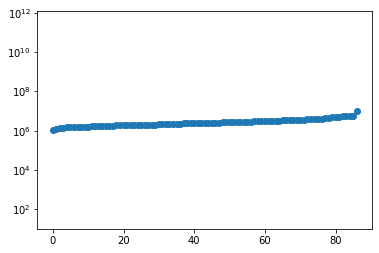

In [85]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
%matplotlib inline
inc = list(map(lambda x : x['income'], incomes))
#plt.yscale('log')
plt.scatter(range(len(incomes)), sorted(inc))

In [71]:
data = pd.DataFrame(list(map(lambda x : x['income'], incomes)))


/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/xallt/.local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=1,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1])